## В этом ноутбуке исследуется загрузка набора данных с `Huggingface`, загрузка и дообучение модели `Resnet50`. 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoModelForImageClassification, AutoFeatureExtractor, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import warnings
warnings.filterwarnings('ignore')

ImportError: tokenizers>=0.21,<0.22 is required for a normal functioning of this module, but found tokenizers==0.20.3.
Try: `pip install transformers -U` or `pip install -e '.[dev]'` if you're working with git main

### Загрузка данных с `Huggingface`

In [89]:
dataset = load_dataset("sagecontinuum/smokedataset")

In [90]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 14318
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 3671
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1843
    })
})

## Предобработка

In [91]:
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/resnet-50")

In [131]:
feature_extractor

ConvNextFeatureExtractor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextFeatureExtractor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

In [94]:
def transform(example):
    example["pixel_values"] = feature_extractor(example["image"], return_tensors="pt")["pixel_values"][0]
    return example

dataset = dataset.map(transform, remove_columns=[])

Map:   0%|          | 0/14318 [00:00<?, ? examples/s]

Map:   0%|          | 0/3671 [00:00<?, ? examples/s]

Map:   0%|          | 0/1843 [00:00<?, ? examples/s]

In [95]:
def collate_fn(batch):
    pixel_values = torch.stack([torch.tensor(example["pixel_values"]) for example in batch])  # Преобразуем список в Tensor
    labels = torch.tensor([example["label"] for example in batch], dtype=torch.long)  # dtype важно для cross-entropy loss
    return {"pixel_values": pixel_values, "labels": labels}

In [96]:
num_classes = len(set(dataset["train"]["label"]))
print(f"Количество классов: {num_classes}, примеры меток: {set(dataset['train']['label'])}")

Количество классов: 3, примеры меток: {0, 1, 2}


## Создание и обучение модели

In [97]:
model = AutoModelForImageClassification.from_pretrained("microsoft/resnet-50", num_labels=num_classes, ignore_mismatched_sizes=True)

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([3, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [102]:
# Функция для вычисления метрик на каждой эпохе
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)  

    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [103]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  
    save_strategy="epoch",  
    logging_strategy="epoch",  
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

In [104]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics
)

In [105]:
# Запуск обучения
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.785200,0.412550,0.957777,0.957898,0.957777,0.957822
2,0.332900,0.170805,0.970308,0.970299,0.970308,0.970242
3,0.244900,0.125588,0.975756,0.975751,0.975756,0.975748


TrainOutput(global_step=2685, training_loss=0.45432276095313956, metrics={'train_runtime': 3592.6199, 'train_samples_per_second': 11.956, 'train_steps_per_second': 0.747, 'total_flos': 9.122250091352187e+17, 'train_loss': 0.45432276095313956, 'epoch': 3.0})

In [1]:
# Оценка на тестовом датасете
eval_results = trainer.evaluate(dataset["test"])
for k, v in eval_results.items():
    print(f"{k}: {v}")

NameError: name 'trainer' is not defined

### Визуализация результатов

In [115]:
import matplotlib.pyplot as plt

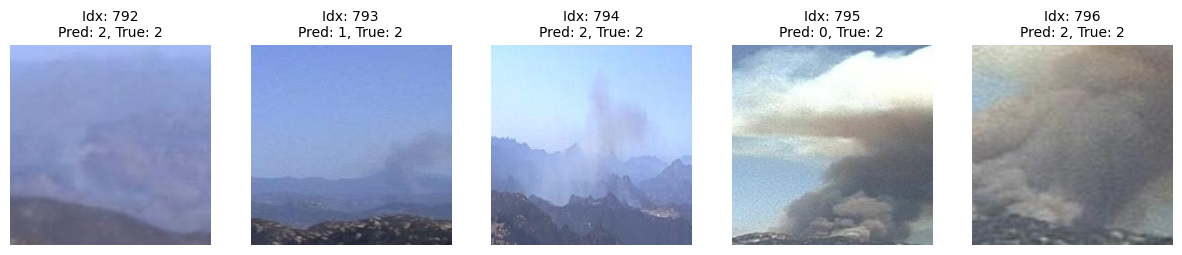

In [125]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

# Преобразуем PIL.Image в тензор и нормализуем значения в [0, 1]
def normalize_image(image):
    transform = transforms.Compose([
        transforms.ToTensor(),  # Конвертируем PIL.Image в тензор [C, H, W]
        transforms.Lambda(lambda x: torch.clamp(x, 0, 1))  # Обрезаем значения в [0, 1]
    ])
    return transform(image)

# Функция для предсказания на одном изображении
def predict_image(model, image, feature_extractor):
    model.eval()
    inputs = feature_extractor(image, return_tensors="pt")
    pixel_values = inputs["pixel_values"]

    with torch.no_grad():
        outputs = model(pixel_values)
        logits = outputs.logits
        pred_label = torch.argmax(logits, dim=1).item()

    return pred_label

# Функция для отображения изображений с label = target_label
def show_predictions_with_label(model, dataset, feature_extractor, target_label=2, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    found = 0  # Считаем количество изображений с label = target_label

    for i in range(len(dataset["test"])):
        if found >= num_images:
            break

        example = dataset["test"][i]
        if example["label"] != target_label:
            continue

        # Оригинальное изображение
        image = example["image"]

        # Нормализация в диапазон [0, 1]
        image_tensor = normalize_image(image)  # Преобразуем PIL в тензор и нормализуем
        image_np = image_tensor.permute(1, 2, 0).numpy()  # [C, H, W] → [H, W, C]

        # Предсказание модели
        pred_label = predict_image(model, example["image"], feature_extractor)

        # Отображение изображения
        axes[found].imshow(image_np)
        axes[found].axis("off")
        axes[found].set_title(f"Idx: {i}\nPred: {pred_label}, True: {example['label']}", fontsize=10)

        found += 1

    plt.show()

show_predictions_with_label(model, dataset, feature_extractor, target_label=2, num_images=5)

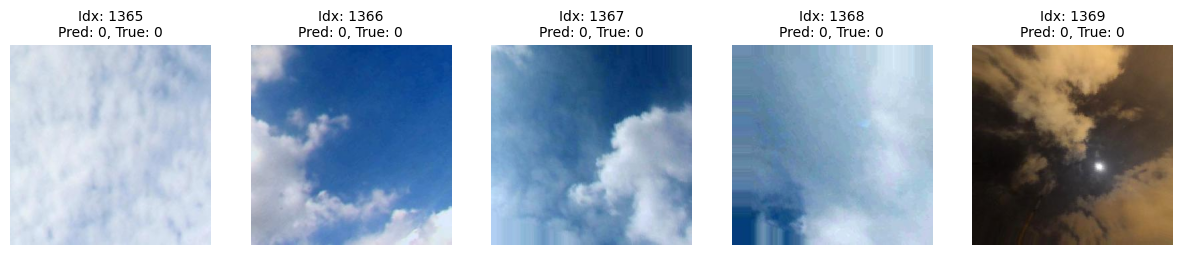

In [129]:
show_predictions_with_label(model, dataset, feature_extractor, target_label=0, num_images=5)